# Handwritting - Page Detection
Finding a page in the image

## Import Packages

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

print("OpenCV: " + cv2.__version__)
print("Numpy: " + np.__version__)
print("Pandas: " + pd.__version__)

OpenCV: 3.1.0-dev
Numpy: 1.11.2
Pandas: 0.17.1


## Finding Page
This part will find the page and delete the unnacessary background.

In [22]:
SMALL_HEIGHT = 800         # Image scaling
IMG = "11"               # Image name/number

### Help Functions

In [23]:
def implt(img, cmp=None, t=''):
    """ Show image using plt """
    plt.imshow(img, cmap=cmp)
    plt.title(t)
    plt.show()
    
    
def resize(img, height=SMALL_HEIGHT):
    """ Resize image to given height """
    rat = height / img.shape[0]
    return cv2.resize(img, (int(rat * img.shape[1]), height))


def ratio(img, height=SMALL_HEIGHT):
    """ Scale ratio """
    return img.shape[0] / height

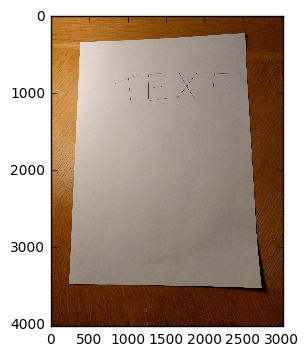

In [24]:
# Loading images and ploting it (converting to RGB from BGR)
image = cv2.cvtColor(cv2.imread("data/pagedet/%s.jpg" % IMG), cv2.COLOR_BGR2RGB)
implt(image)

In [27]:
def edgesDet(img, minVal, maxVal):
    """ Preprocessing (gray, thresh, filter, border) + Canny edge detection """
    img = cv2.cvtColor(resize(img), cv2.COLOR_BGR2GRAY)

    # img = cv2.medianBlur(img, 11)
    # img = cv2.GaussianBlur(img, (7, 7), 0)
    # TODO Try bilateralFilter before converting colors...
    img = cv2.bilateralFilter(img, 9, 75, 75)
    img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 115, 4)
    implt(img, 'gray', 'Adaptive Threshold')

    # Median blur replace center pixel by median of pixels under kelner
    # => removes thin details
    img = cv2.medianBlur(img, 11)

    # Add black border - detection of border touching pages
    img = cv2.copyMakeBorder(img, 5, 5, 5, 5, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    implt(img, 'gray', 'Median Blur + Border')
    cv2.imwrite("data/textdet/%s-blur.jpg" % IMG, img)

    # TODO threshold probably unnecessary
    # ret, th = cv2.threshold(cv2.morphologyEx((255-img), cv2.MORPH_OPEN, np.ones((5, 5),np.uint8)),
    #                     115, 255, cv2.THRESH_BINARY)

    return cv2.Canny(img, minVal, maxVal)  # L2gradient=True, increase precision?

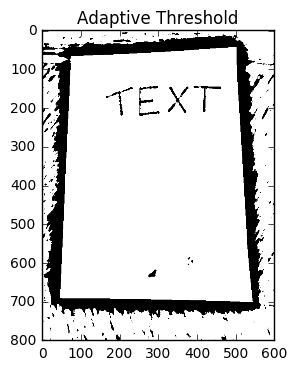

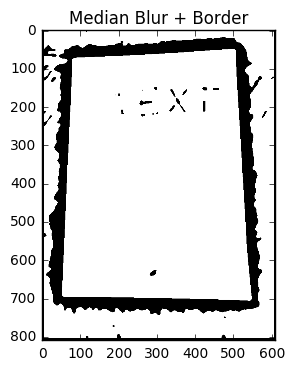

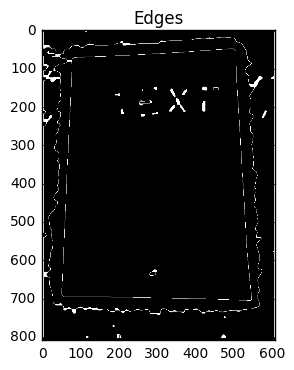

In [28]:
# Edge detection ()
imageEdges = edgesDet(image, 200, 250)

# Close gaps between edges (double page clouse => rectangle kernel)
closedEdges = cv2.morphologyEx(imageEdges, cv2.MORPH_CLOSE, np.ones((5, 11)))
implt(closedEdges, 'gray', 'Edges')

In [ ]:
def fourCornersSort(pts):
    """ Sort corners: top-left, bot-left, bot-right, top-right"""
    diff = np.diff(pts, axis=1)
    summ = pts.sum(axis=1)
    return np.array([pts[np.argmin(summ)],
                     pts[np.argmax(diff)],
                     pts[np.argmax(summ)],
                     pts[np.argmin(diff)]])


def contourOffset(cnt, offset):
    """ Offset contour because of 5px border """
    cnt += offset
    cnt[cnt < 0] = 0
    return cnt


def findPageContours(edges, img):
    """ Finding corner points of page contour """
    # Getting contours  
    im2, contours, hierarchy = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    # Finding biggest rectangle otherwise return original corners
    height = edges.shape[0]
    width = edges.shape[1]
    MIN_COUNTOUR_AREA = height * width * 0.5
    MAX_COUNTOUR_AREA = (width - 10) * (height - 10)

    maxArea = MIN_COUNTOUR_AREA
    pageContour = np.array([[0, 0],
                            [0, height],
                            [width, height],
                            [width, 0]])

    for cnt in contours:
        perimeter = cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, 0.03 * perimeter, True)

        # Page has 4 corners and it is convex
        if (len(approx) == 4 and
                cv2.isContourConvex(approx) and
                maxArea < cv2.contourArea(approx) < MAX_COUNTOUR_AREA):
            
            maxArea = cv2.contourArea(approx)
            pageContour = approx

    # Sort corners and offset them
    pageContour = fourCornersSort(pageContour[:, 0])
    return contourOffset(pageContour, (-5, -5))

In [ ]:
pageContour = findPageContours(closedEdges, resize(image))
print("PAGE CONTOUR:")
print(pageContour)
implt(cv2.drawContours(resize(image), [pageContour], -1, (0, 255, 0), 3))
       
# Recalculate to original scale
pageContour = pageContour.dot(ratio(image))

In [ ]:
def perspImageTransform(img, sPoints):
    """ Transform perspective from start points to target points """
    # Euclidean distance - calculate maximum height and width
    height = max(np.linalg.norm(sPoints[0] - sPoints[1]),
                 np.linalg.norm(sPoints[2] - sPoints[3]))
    width = max(np.linalg.norm(sPoints[1] - sPoints[2]),
                 np.linalg.norm(sPoints[3] - sPoints[0]))
    
    # Create target points
    tPoints = np.array([[0, 0],
                        [0, height],
                        [width, height],
                        [width, 0]], np.float32)
    
    # getPerspectiveTransform() needs float32
    if sPoints.dtype != np.float32:
        sPoints = sPoints.astype(np.float32)
    
    M = cv2.getPerspectiveTransform(sPoints, tPoints) 
    return cv2.warpPerspective(img, M, (int(width), int(height)))
    
    
newImage = perspImageTransform(image, pageContour)
implt(newImage, t='Result')

## Saving / Exporting image

In [ ]:
# Save cropped image
cv2.imwrite("data/textdet/%s.jpg" % IMG, cv2.cvtColor(newImage, cv2.COLOR_BGR2RGB))